# Multi-layer Perceptron (MLP)

### Libraries & Settings
---

In [27]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns  

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all rows


#### Kaggle Competition Performance Metric:

$$\log \text { Loss }=\frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0 i} \log p_{0 i}-\frac{1}{N_1} \sum_{i=1}^{N_1} y_{1 i} \log p_{1 i}}{2}$$

#### Define Processing Functions

In [2]:
def dummy_creator(feature_list, df):
    
    dummy_dfs = []
    
    for feat in feature_list:
        dummy_df = pd.get_dummies(df[feat], prefix=feat, dtype=int)
        dummy_dfs.append(dummy_df)
        df.drop(feat, axis=1, inplace=True)  
        
    df_with_dummies = pd.concat([df] + dummy_dfs, axis=1)
    
    return df_with_dummies

### Import & Preprocess Data
---

In [3]:
# read main data
data_df = pd.read_csv('../Kaggle_Files/train.csv')
print(f'Dataset Shape: {data_df.shape}')
data_df.head()

Dataset Shape: (617, 58)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
# read metadata
meta_df = pd.read_csv('../Kaggle_Files/greeks.csv')
print(f'Dataset Shape: {meta_df.shape}')
meta_df.head()

Dataset Shape: (617, 6)


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
# merge data and metadata
merged_df = data_df.merge(meta_df, left_on='Id', right_on='Id')
merged_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [6]:
# drop 'Alpha', 'Gamma', and 'Epsilon'

merged_df = merged_df.drop(['Id','Alpha', 'Gamma', 'Epsilon'], axis=1)
merged_df.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Beta',
       'Delta'],
      dtype='object')

In [7]:
# create dummy features for categorical features

dummy_list = ['EJ','Beta', 'Delta']
merged_df = dummy_creator(dummy_list, merged_df)
merged_df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,EJ_A,EJ_B,Beta_A,Beta_B,Beta_C,Delta_A,Delta_B,Delta_C,Delta_D
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,1,0,0,0,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,1,0,1,0,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,1,0,0,1,0,1,0,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,1,0,0,1,0,1,0,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,1,0,1,0,0,1,0,0


In [8]:
# split train/test

labels = ['Class']
y = merged_df[labels].values

features = [i for i in merged_df.columns if i not in labels] 
X = merged_df[features].values


# shuffle and split
split = (0.8,0.2) #80% training and 20% test
shuffle = np.random.permutation(np.arange(y.shape[0])) 
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# recombine shuffled train and test dfs
train_df = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1)

test_df = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1)

# rename columns
train_df.columns = labels + features
test_df.columns = labels + features

train_df.head()

,Class,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B,Beta_A,Beta_B,Beta_C,Delta_A,Delta_B,Delta_C,Delta_D
0,0,0.252107,6573.89612,85.200147,6.791721,8.138688,3.260112,0.025578,3.396778,1.229900,2215.14760,21.1860,108.018198,101.696595,424.791025,257.432377,16.130205,1.055008,44.262024,4.841272,0.029054,1.050225,0.631125,23.321056,0.446877,37.844200,30.31444,358.130685,0.238680,0.248703,60.232470,10.34560,23.460912,0.005518,1.74307,20.227476,4.926396,2.487127,1148.985575,0.003042,109.125159,164.024224,3.828384,47.472432,0.29685,2763.816228,8.363221,0.173229,1.10606,0.067730,8.409008,72.611063,14650.266850,36.681618,0.897628,21.978000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,0.499941,3364.77889,85.200147,32.506112,8.254056,1.869249,0.025578,3.396778,1.229900,3596.08327,22.9515,85.169988,116.190815,51.216883,257.432377,12.499760,0.471681,53.403008,5.038937,0.019104,1.050225,0.385350,18.571762,0.844101,7.030640,27.22984,69.261395,3.463317,0.207708,177.128190,61.45032,15.845328,1.717353,1.74307,16.463180,4.926396,1.443098,716.125475,0.006084,109.125159,78.526968,61.978296,34.449072,0.29685,12698.221080,5.529539,18.722654,1.49669,0.318331,18.445866,72.611063,2119.561668,33.883426,19.470040,0.002386,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0.316202,2688.97090,85.200147,12.090688,8.138688,5.926671,0.025578,8.539210,1.229900,3872.17772,24.0108,135.787887,79.345695,51.216883,257.432377,33.685015,0.732353,91.671464,9.533535,0.035024,1.050225,1.032150,30.556581,1.616481,7.030640,96.89912,135.817440,0.238680,0.511071,98.127195,67.61528,39.360832,0.005518,1.74307,29.121636,7.492080,1.354416,1561.264275,0.003042,39.191295,87.517898,18.544368,21.654192,0.29685,7528.153666,10.573934,0.173229,0.49706,0.406380,12.129808,72.611063,44792.362530,42.709638,19.081668,21.978000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0.132463,1777.81186,85.200147,18.591291,8.138688,4.544667,0.115710,9.856328,8.531992,4298.32437,15.8895,127.428579,27.482750,491.971219,1185.637154,28.179606,0.547878,88.199000,11.616620,0.021094,1.050225,0.739050,45.114806,1.655100,38.240904,37.77956,151.051665,0.238680,0.481008,115.254180,101.50560,20.663072,0.005518,1.74307,21.907484,10.531320,0.685270,898.954100,0.003042,47.339721,224.078075,47.662368,46.010160,0.29685,7551.375238,9.719419,0.173229,2.03464,0.088049,17.320324,146.586979,12008.379600,29.116825,21.291016,21.978000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,0.807597,2174.83464,89.768017,88.546327,17.908260,6.032979,0.236901,13.848645,11.416986,4854.54023,26.4825,277.684173,214.451415,1186.883364,2421.524634,103.044896,0.387573,74.483560,20.917518,0.034626,1.050225,0.771675,63.981220,1.153053,36.474596,58.13016,330.760083,1.263600,0.344358,186.792945,107.31864,31.288040,0.005518,1.74307,33.231816,22.006218,1.521702,2103.577538,0.003042,109.125159,268.671234,42.388212,64.825488,0.29685,4906.122278,10.584960,0.173229,2.86346,0.507975,23.129423,72.611063,31771.629380,19.196639,49.019748,21.978000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [9]:
# columns with missing values 
sum_null = train_df.isnull().sum()
sum_null[sum_null != 0]

BQ    49
CB     2
CC     3
DU     1
EL    48
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [10]:
# mean imputation
train_mean_vals = train_df.mean()

train_df.fillna(train_mean_vals, inplace=True)
test_df.fillna(train_mean_vals, inplace=True)

In [11]:
# split features from label
X_train = train_df[features]
y_train = train_df[labels].values
X_test = test_df[features]
y_test = test_df[labels].values

In [12]:
# standardize features
sc = StandardScaler()

X_train_std = sc.fit(X_train).transform(X_train)
X_test_std = sc.fit(X_train).transform(X_test)

### Import Preprocessed Data
---

In [134]:
# if needed

### Build MLP Model
---

In [440]:
def mlp_build(n_features=len(X_train.columns),
              hidden_layer_sizes=[],
              activation='relu',
              optimizer='Adam',
              learning_rate=0.01):
    
    """Build a multi-layer perpectrong model using Keras.

    Args:
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use.
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    A tf.keras model.
    
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(n_features,), name='Input'))
    
    for idx, hidden_layer_size in enumerate(hidden_layer_sizes):
        
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation,
                                        use_bias=True,
                                        name='Hidden_'+str(idx)))
        
    model.add(tf.keras.layers.Dense(units=1, 
                                    activation='sigmoid',
                                    use_bias=True,
                                    name='Output'))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=eval("tf.keras.optimizers." + optimizer + "(learning_rate="+ str(learning_rate) + ")"),
                  metrics=['accuracy', keras.metrics.AUC(name='prc', curve='PR')])

    return model

### Train MLP Model
---

In [438]:
def mlp_train(num_epochs=5, batch=64, train_data=[None,None]):
    """
    
    Args:   num_epochs: the number of epochs
            batch: the batch size
            train_data: list with training data e.g train_data=[X_train, y_train]
    
    Outputs: The model.summary() and plots: loss, accuracy, and AUC-PRC.
    
    Returns: model
            
    """

    # Build the model
    model = mlp_build(n_features,
                      hidden_layer_sizes,
                      activation,
                      optimizer,
                      learning_rate)
    print(model.summary())

    # Train the model
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  min_delta=5e-3,
                                                  patience=0,
                                                  verbose=1,
                                                  mode='auto',
                                                  restore_best_weights=False,
                                                  start_from_epoch=0)
    
    history = model.fit(x=train_data[0],
                        y=train_data[1],
                        epochs=num_epochs,
                        batch_size=batch,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=[stop_early])
    
    # plot metrics
    metrics = [i for i in history.history.keys() if 'val_' not in i]
    x_ticks = np.array(history.epoch)+1
    
    fig = plt.figure(figsize=(6*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax = fig.add_subplot(1, len(metrics), idx+1)
        ax.plot(x_ticks, history.history[metric], '-o', label='Training')
        ax.plot(x_ticks, history.history['val_'+metric], '-o', label='Validation')
        ax.legend(fontsize=13)
        ax.set_xlabel('epoch', size=15)
        ax.set_xticks(x_ticks)
        ax.set_ylabel(metric, size=15)
        
    plt.show()
    
    return model
    

#### Hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1950      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1,981
Trainable params: 1,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 3s 303ms/step - loss: 0.5913 - accuracy: 0.6904 - prc: 0.4781 - val_loss: 0.4646 - val_accuracy: 0.8283 - val_prc: 0.6160
Epoch 2/50
7/7 [==============================] - 1s 75ms/step - loss: 0.2675 - accuracy: 0.8934 - prc: 0.7866 - val_loss: 0.3623 - val_accuracy: 0.8081 - val_prc: 0.7026
Epoch 3/50
7/7 [==============================] - 0s 53ms/step - loss: 0.1978 - accuracy: 0.9137 - prc

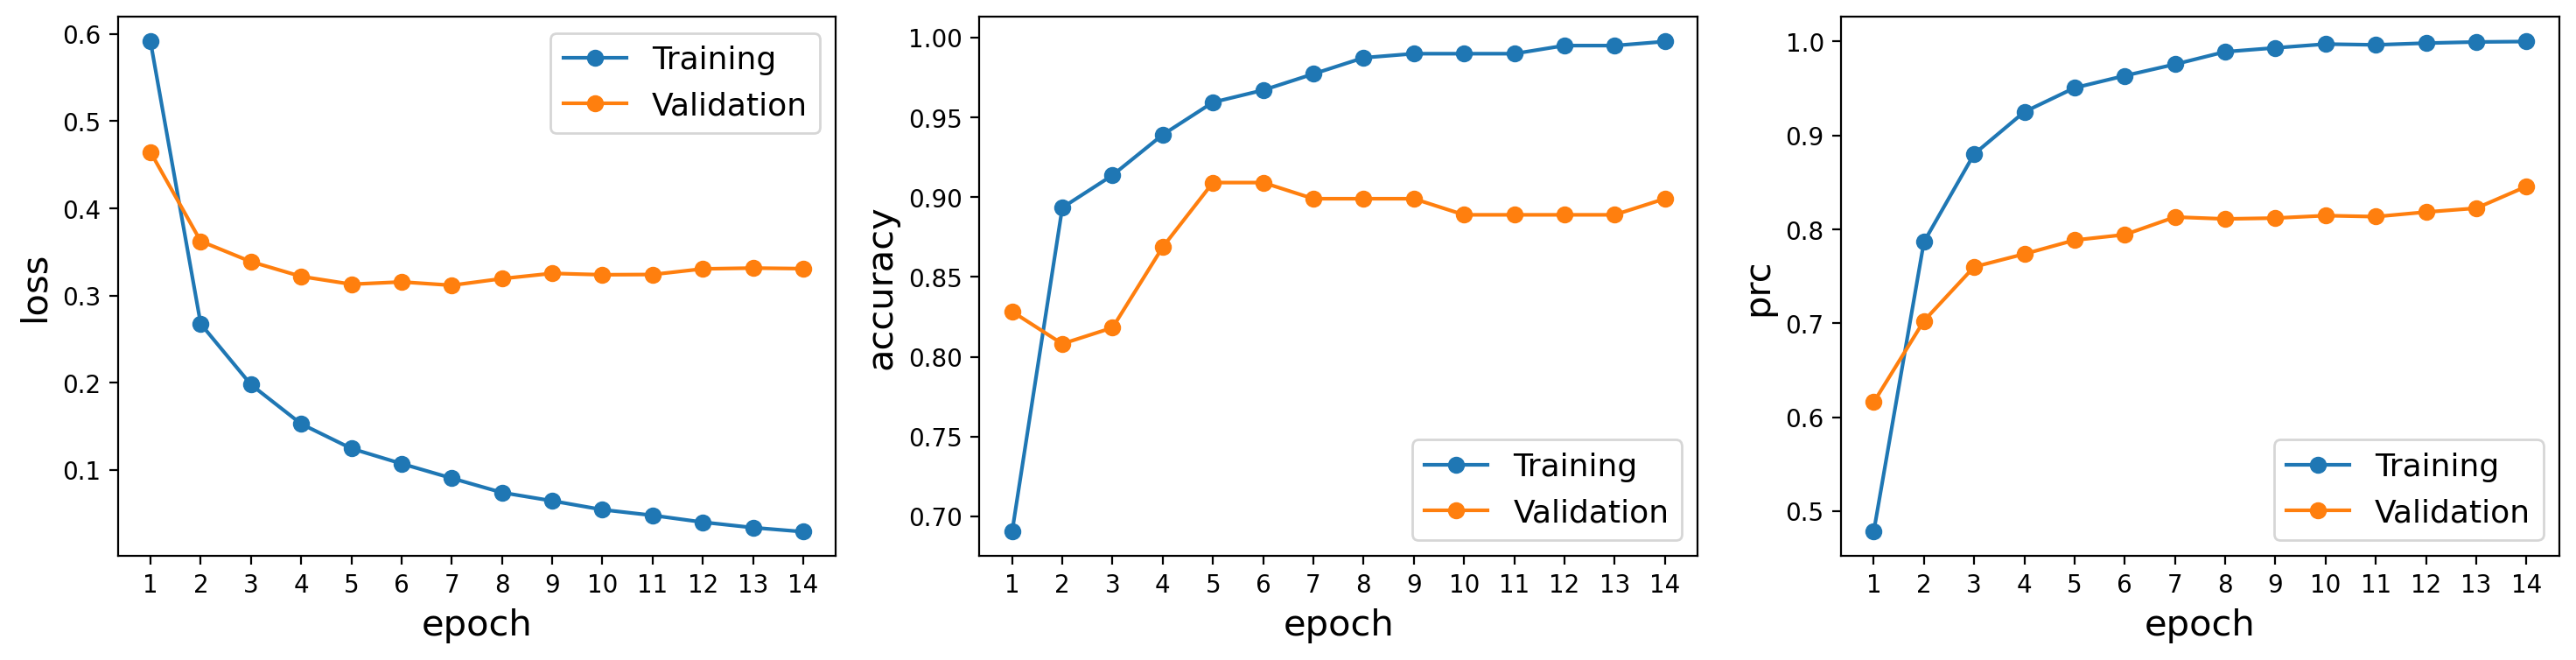

In [422]:
train_data=[X_train_std, y_train]
n_features=len(features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.01
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

### Evaluate Test Set
---

#### Define Performance Function

In [368]:
def balanced_log_loss(y_true, y_pred):
    y_true, y_pred = y_true.flatten(), y_pred.flatten()
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

In [219]:
model_eval = model.evaluate(x=X_test_std, y=y_test,
                               verbose=0,
                               return_dict=True)
y_test_pred = model.predict(x=X_test_std, verbose=0)

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_test == 0)/len(y_test)))
print('Test Accuracy:     %1.4f' %(model_eval['accuracy']))
print('\nAUC-PRC:           %1.4f' %(model_eval['prc']))
print('Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, y_test_pred)))


Baseline:          0.8468
Test Accuracy:     0.9516

AUC-PRC:           0.9176
Balanced Log Loss: 0.3575


## MLP Model with Balanced Data
---

Label Counts:
0    509
1    108
Name: Class, dtype: int64


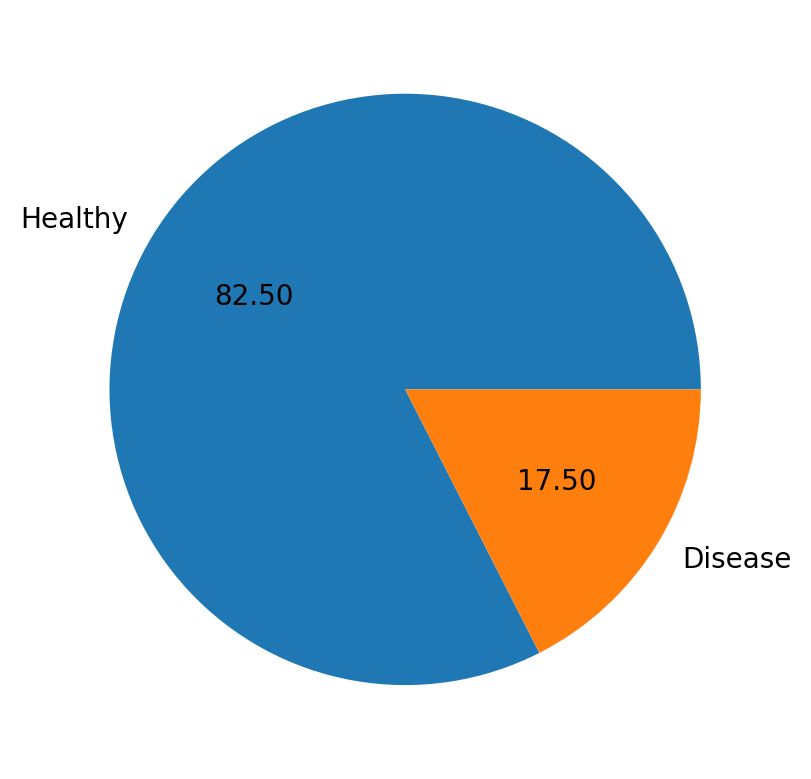

In [146]:
# check class imbalance
class_values_cnts = merged_df['Class'].value_counts()
print(f'Label Counts:\n{class_values_cnts}')
plt.pie(class_values_cnts, labels=['Healthy', 'Disease'], autopct='%.2f')
plt.show()

In [264]:
# downsample to 108 per class
neg_df = merged_df[merged_df.Class.eq(0)].sample(n=108, replace=False, axis=0, 
                                                        random_state=0, ignore_index=False)
pos_df = merged_df[merged_df.Class.eq(1)]

# split 60/20/20
neg_test_df  = neg_df.sample(frac=0.2, random_state=0)
neg_temp_df  = neg_df.drop(neg_test_df.index)
neg_val_df   = neg_temp_df.sample(frac=0.25, random_state=0)
neg_train_df = neg_temp_df.drop(neg_val_df.index)

pos_test_df  = pos_df.sample(frac=0.2, random_state=0)
pos_temp_df  = pos_df.drop(pos_test_df.index)
pos_val_df   = pos_temp_df.sample(frac=0.25, random_state=0)
pos_train_df = pos_temp_df.drop(pos_val_df.index)


In [265]:
# mean imputation
bal_temp_df = pd.concat([neg_temp_df, pos_temp_df], axis=0)
bal_temp_mean_vals = bal_temp_df.mean()

neg_train_df.fillna(bal_temp_mean_vals, inplace=True)
pos_train_df.fillna(bal_temp_mean_vals, inplace=True)
neg_val_df.fillna(bal_temp_mean_vals, inplace=True)
pos_val_df.fillna(bal_temp_mean_vals, inplace=True)
neg_test_df.fillna(bal_temp_mean_vals, inplace=True)
pos_test_df.fillna(bal_temp_mean_vals, inplace=True)

In [280]:
# recombine train, validation, and test datasets
bal_train_df = pd.concat([neg_train_df, pos_train_df], axis=0)
bal_val_df   = pd.concat([neg_val_df, pos_val_df], axis=0)
bal_test_df   = pd.concat([neg_test_df, pos_test_df], axis=0)

#shuffle balanced datasets
bal_train_df = bal_train_df.sample(frac=1, random_state=0, ignore_index=True)
bal_val_df   = bal_val_df.sample(frac=1, random_state=0, ignore_index=True)
bal_test_df  = bal_test_df.sample(frac=1, random_state=0, ignore_index=True)

In [369]:
# split features from labels
X_train_bal_df = bal_train_df[features]
y_train_bal    = bal_train_df[labels].values
X_val_bal_df   = bal_val_df[features]
y_val_bal      = bal_val_df[labels].values
X_test_bal_df  = bal_test_df[features]
y_test_bal     = bal_test_df[labels].values

In [370]:
# standardize features
X_temp_bal_df = bal_temp_df[features]

sc = StandardScaler()

X_train_bal_std = sc.fit(X_temp_bal_df).transform(X_train_bal_df)
X_val_bal_std   = sc.fit(X_temp_bal_df).transform(X_val_bal_df)
X_test_bal_std  = sc.fit(X_temp_bal_df).transform(X_test_bal_df)

### Train MLP Model with Separate Validation Data
---

In [439]:
def mlp_train_val(num_epochs=5, batch=64, train_data=[None,None], val_data=(None,None)):
    """
    
    Args:   num_epochs: the number of epochs
            batch: the batch size
            train_data: list with training data e.g train_data = [X_train, y_train]
            val_data = tuple with validation data e.g. val_data = (X_val, y_val)
    
    Outputs: The model_summary() and plots: loss, accuracy, and AUC-PRC.
    
    Returns: model
            
    """

    # Build the model
    model = mlp_build(n_features,
                      hidden_layer_sizes,
                      activation,
                      optimizer,
                      learning_rate)
    print(model.summary())

    # Train the model
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  min_delta=5e-3,
                                                  patience=0,
                                                  verbose=1,
                                                  mode='auto',
                                                  restore_best_weights=False,
                                                  start_from_epoch=0)
    
    history = model.fit(x=train_data[0],
                        y=train_data[1],
                        epochs=num_epochs,
                        batch_size=batch,
                        validation_data=val_data,
                        verbose=1,
                        callbacks=[stop_early])

    # plot metrics
    metrics = [i for i in history.history.keys() if 'val_' not in i]
    x_ticks = np.array(history.epoch)+1
    
    fig = plt.figure(figsize=(6*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax = fig.add_subplot(1, len(metrics), idx+1)
        ax.plot(x_ticks, history.history[metric], '-o', label='Training')
        ax.plot(x_ticks, history.history['val_'+metric], '-o', label='Validation')
        ax.legend(fontsize=13)
        ax.set_xlabel('epoch', size=15)
        ax.set_xticks(x_ticks)
        ax.set_ylabel(metric, size=15)
    
    plt.show()
    
    return model
    

#### Hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 20)                1300      
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
2/2 [==============================] - 1s 762ms/step - loss: 0.8584 - accuracy: 0.4844 - prc: 0.4981 - val_loss: 0.8723 - val_accuracy: 0.4091 - val_prc: 0.4281
Epoch 2/50
2/2 [==============================] - 0s 198ms/step - loss: 0.6320 - accuracy: 0.6484 - prc: 0.7678 - val_loss: 0.7257 - val_accuracy: 0.4318 - val_prc: 0.5809
Epoch 3/50
2/2 [==============================] - 0s 198ms/step - loss: 0.4888 - accuracy: 0.7969 - p

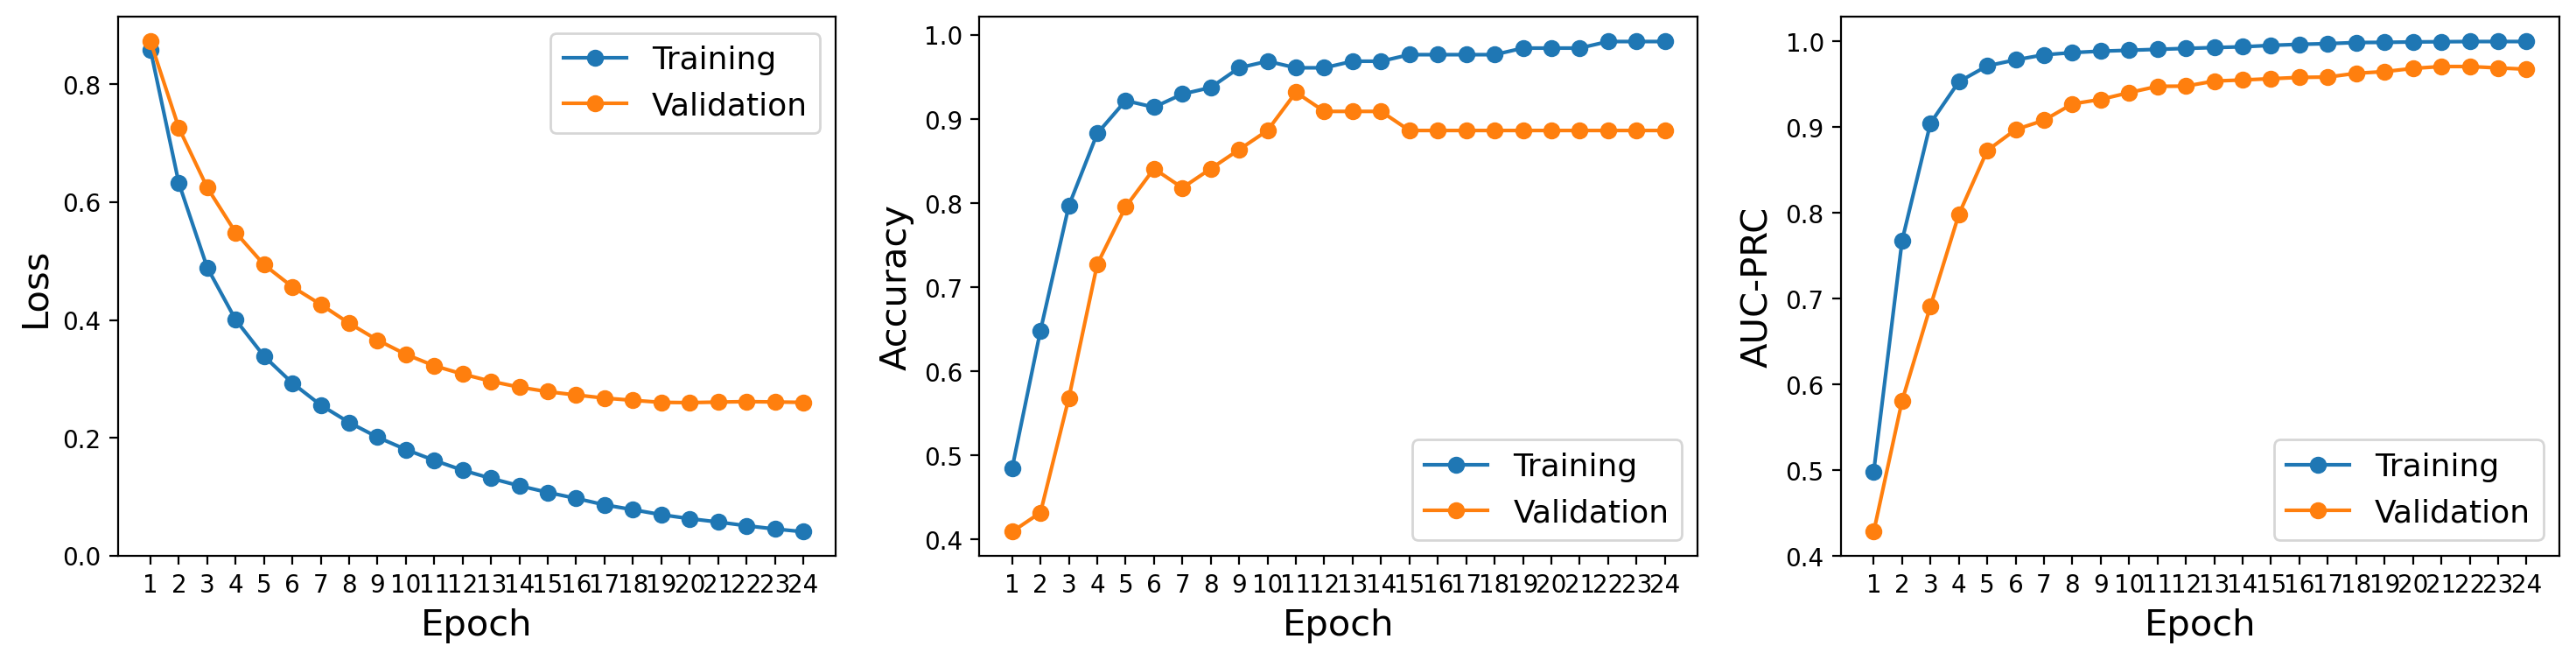

In [376]:
train_data = [X_train_bal_std, y_train_bal]
val_data = (X_val_bal_std, y_val_bal)
n_features = len(features)
hidden_layer_sizes = [20]
activation = 'relu'
optimizer = 'Adam'
learning_rate = 0.01
num_epochs = 50
batch = 64

model = mlp_train_val(num_epochs, batch, train_data, val_data)

### Evaluate Balanced Test Set
---

In [378]:
model_bal_eval = model.evaluate(x=X_test_bal_std, y=y_test_bal,
                                verbose=0, return_dict=True)

y_test_bal_pred = model.predict(x=X_test_bal_std, verbose=0)

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_test_bal == 0)/len(y_test_bal)))
print('Test Accuracy:     %1.4f' %(model_bal_eval['accuracy']))
print('\nAUC-PRC:           %1.4f' %(model_bal_eval['prc']))
print('Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test_bal, y_test_bal_pred)))


Baseline:          0.5000
Test Accuracy:     0.9091

AUC-PRC:           0.9619
Balanced Log Loss: 0.2532
